In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rm1000/brain-tumor-mri-scans")

print("Path to dataset files:", path)

100%|██████████| 236M/236M [00:22<00:00, 10.8MB/s] 

Extracting files...


Path to dataset files: /Users/ignaciovigilcardenal/.cache/kagglehub/datasets/rm1000/brain-tumor-mri-scans/versions/1


--- Step 1: Loading and Resizing Images ---
Processing folder: glioma
Processing folder: healthy
Processing folder: meningioma
Processing folder: pituitary

Loaded 7023 images.
Loaded 7023 labels.
Shape of X_raw (all_resized_images): (7023, 128, 128)
Shape of y_raw (all_labels): (7023,)


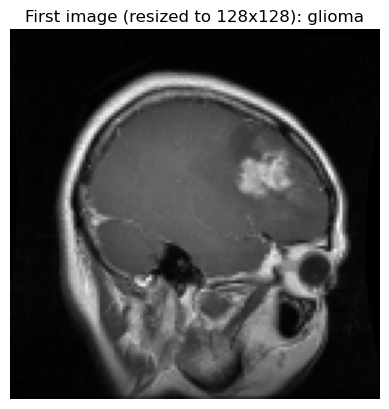


--- Step 2: Encoding Labels and Splitting Data ---
Label mapping: ['glioma', 'healthy', 'meningioma', 'pituitary'] -> [0, 1, 2, 3]

Training set images shape (raw): (5618, 128, 128)
Training set labels shape: (5618,)
Testing set images shape (raw): (1405, 128, 128)
Testing set labels shape: (1405,)

--- Step 3: Normalize Pixel Values ---
Training set images shape (normalized): (5618, 128, 128)
Testing set images shape (normalized): (1405, 128, 128)

--- Step 4: Extract HOG Features ---
Extracting HOG features from training set...
HOG feature extraction for training set took: 24.89 seconds
Extracting HOG features from testing set...
HOG feature extraction for testing set took: 6.21 seconds
Shape of X_train_hog (features for classifier): (5618, 8100)
Shape of X_test_hog (features for classifier): (1405, 8100)


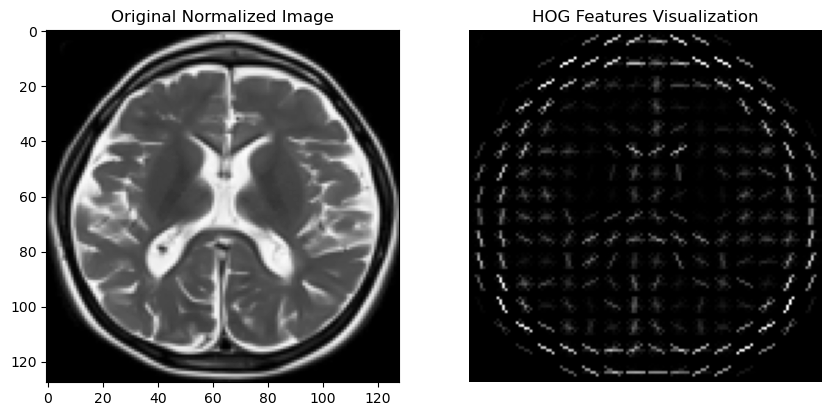

In [28]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt # For displaying images
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from skimage.feature import hog # <--- Make sure to import hog from skimage
from skimage import exposure # For visualizing HOG (optional)


# List of your class names (folder names)
class_names = ['glioma', 'healthy', 'meningioma', 'pituitary']

# Define a common size for all images
TARGET_SIZE = (128, 128) # (width, height) - OpenCV uses (width, height) for size

# Initialize lists to store image data and corresponding labels
# We'll store the raw resized images first, then extract HOG features later.
all_resized_images = []
all_labels = []

print("--- Step 1: Loading and Resizing Images ---")
# Loop through each class (folder)
for class_name in class_names:
    class_folder_path = os.path.join(class_name) 
    print(f"Processing folder: {class_folder_path}")

    # Check if the folder exists
    if not os.path.exists(class_folder_path):
        print(f"Warning: Folder '{class_folder_path}' not found. Skipping.")
        continue

    # Loop through each image file in the current class folder
    for image_name in os.listdir(class_folder_path):
        # Only process actual image files, not directories or hidden files
        if image_name.endswith(('.jpg')):
            image_path = os.path.join(class_folder_path, image_name)

            image = cv2.imread(image_path, 0) # Read in grayscale (0)

            if image is not None:
                # Resize the image to the TARGET_SIZE
                # cv2.resize takes (width, height) as the dsize argument
                resized_image = cv2.resize(image, TARGET_SIZE, interpolation=cv2.INTER_AREA)
                all_resized_images.append(resized_image)
                all_labels.append(class_name)
            else:
                print(f"Warning: Could not load image {image_path}. Skipping.")

print(f"\nLoaded {len(all_resized_images)} images.")
print(f"Loaded {len(all_labels)} labels.")

# Convert lists to NumPy arrays for easier processing
X_raw = np.array(all_resized_images)
y_raw = np.array(all_labels)

print(f"Shape of X_raw (all_resized_images): {X_raw.shape}") # Should be (num_images, TARGET_SIZE[1], TARGET_SIZE[0])
print(f"Shape of y_raw (all_labels): {y_raw.shape}")

# Example: Display the first image and its label
if len(X_raw) > 0:
    plt.imshow(X_raw[0], cmap='gray')
    plt.title(f"First image (resized to {TARGET_SIZE[0]}x{TARGET_SIZE[1]}): {y_raw[0]}")
    plt.axis('off')
    plt.show()
else:
    print("No images loaded to display.")


print("\n--- Step 2: Encoding Labels and Splitting Data ---")
# Continue with label encoding and train-test split
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)
print(f"Label mapping: {list(label_encoder.classes_)} -> {list(label_encoder.transform(label_encoder.classes_))}")

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTraining set images shape (raw): {X_train_raw.shape}")
print(f"Training set labels shape: {y_train.shape}")
print(f"Testing set images shape (raw): {X_test_raw.shape}")
print(f"Testing set labels shape: {y_test.shape}")


print("\n--- Step 3: Normalize Pixel Values ---")
# Normalize pixel values to [0, 1]
# This is crucial for many machine learning algorithms, including HOG and any subsequent classifiers.
X_train_normalized = X_train_raw / 255.0
X_test_normalized = X_test_raw / 255.0

print(f"Training set images shape (normalized): {X_train_normalized.shape}")
print(f"Testing set images shape (normalized): {X_test_normalized.shape}")


print("\n--- Step 4: Extract HOG Features ---")
# HOG parameters (you'll need to tune these)
# orientations: number of gradient orientations
# pixels_per_cell: size of the cell in pixels
# cells_per_block: number of cells in each block
# visualize: returns an image of the HOG features (for debugging)
# feature_vector: returns a flattened feature vector (essential for classifiers)
hog_orientations = 9
hog_pixels_per_cell = (8, 8) # Common starting point
hog_cells_per_block = (2, 2) # Common starting point

X_train_hog_features = []
X_test_hog_features = []

import time # For timing the extraction

print("Extracting HOG features from training set...")
start_time = time.time()
for img in X_train_normalized:
    # Ensure the input to HOG is a 2D array (grayscale image)
    features = hog(img,
                   orientations=hog_orientations,
                   pixels_per_cell=hog_pixels_per_cell,
                   cells_per_block=hog_cells_per_block,
                   feature_vector=True, # We want the flattened feature vector
                   block_norm='L2-Hys') # L2-Hys is a common normalization
    X_train_hog_features.append(features)
X_train_hog = np.array(X_train_hog_features)
end_time = time.time()
print(f"HOG feature extraction for training set took: {end_time - start_time:.2f} seconds")


print("Extracting HOG features from testing set...")
start_time = time.time()
for img in X_test_normalized:
    features = hog(img,
                   orientations=hog_orientations,
                   pixels_per_cell=hog_pixels_per_cell,
                   cells_per_block=hog_cells_per_block,
                   feature_vector=True,
                   block_norm='L2-Hys')
    X_test_hog_features.append(features)
X_test_hog = np.array(X_test_hog_features)
end_time = time.time()
print(f"HOG feature extraction for testing set took: {end_time - start_time:.2f} seconds")

print(f"Shape of X_train_hog (features for classifier): {X_train_hog.shape}")
print(f"Shape of X_test_hog (features for classifier): {X_test_hog.shape}")

# Optional: Visualize a HOG image (for debugging/understanding)
# If you want to visualize, you'd call hog with visualize=True on a single image.
# Example:
sample_image_normalized = X_train_normalized[0]
features_viz, hog_image_viz = hog(sample_image_normalized,
                                   orientations=hog_orientations,
                                   pixels_per_cell=hog_pixels_per_cell,
                                   cells_per_block=hog_cells_per_block,
                                   visualize=True, # Set to True for visualization
                                   feature_vector=False, # Set to False if you only want the image
                                   block_norm='L2-Hys')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax1.imshow(sample_image_normalized, cmap='gray')
ax1.set_title('Original Normalized Image')
hog_image_rescaled = exposure.rescale_intensity(hog_image_viz, in_range=(0, 10))
ax2.imshow(hog_image_rescaled, cmap='gray')
ax2.set_title('HOG Features Visualization')
plt.axis('off')
plt.show()


# Now X_train_hog and X_test_hog are ready for training your classifier!
# Next step would be to import and train your classifier (e.g., SVM).)

In [30]:
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time # For timing

# Assuming X_train_hog, X_test_hog, y_train, y_test are already prepared
# from your previous steps.

# --- Option 1: LinearSVC (One-vs-Rest by default) ---
# LinearSVC is generally faster for linear kernels, especially with large datasets.
# It uses 'ovr' (One-vs-Rest) by default.
print("\n--- Training LinearSVC (One-vs-Rest) ---")
linear_svm_classifier = LinearSVC(random_state=42, C=0.1, max_iter=2000) # C is regularization, tune it! max_iter helps convergence
start_time = time.time()
linear_svm_classifier.fit(X_train_hog, y_train)
end_time = time.time()
print(f"LinearSVC training took: {end_time - start_time:.2f} seconds")

# Predict and Evaluate
y_pred_linear_svm = linear_svm_classifier.predict(X_test_hog)

print("\nLinearSVC Classification Report:")
print(classification_report(y_test, y_pred_linear_svm, target_names=label_encoder.classes_))
print("\nLinearSVC Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_linear_svm))
print(f"LinearSVC Test Accuracy: {accuracy_score(y_test, y_pred_linear_svm):.4f}")


# --- Option 2: SVC with RBF Kernel (One-vs-Rest by default) ---
# SVC is more general and supports various kernels. RBF is a very common non-linear kernel.
# It also uses 'ovr' by default (decision_function_shape='ovr').
print("\n--- Training SVC with RBF Kernel (One-vs-Rest) ---")
rbf_svm_classifier = SVC(kernel='rbf', random_state=42, C=1.0, gamma='scale', probability=True) # C and gamma are key hyperparameters
# probability=True allows predict_proba, but adds computational overhead.
start_time = time.time()
rbf_svm_classifier.fit(X_train_hog, y_train)
end_time = time.time()
print(f"RBF SVM training took: {end_time - start_time:.2f} seconds")

# Predict and Evaluate
y_pred_rbf_svm = rbf_svm_classifier.predict(X_test_hog)

print("\nRBF SVM Classification Report:")
print(classification_report(y_test, y_pred_rbf_svm, target_names=label_encoder.classes_))
print("\nRBF SVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rbf_svm))
print(f"RBF SVM Test Accuracy: {accuracy_score(y_test, y_pred_rbf_svm):.4f}")

# --- Option 3: SVC with One-vs-One strategy (Explicitly using OneVsOneClassifier) ---
# While SVC itself can handle 'ovo' internally with decision_function_shape='ovo',
# using the OneVsOneClassifier wrapper can be clearer for explicit control or if
# you want to wrap a different binary estimator.
from sklearn.multiclass import OneVsOneClassifier

print("\n--- Training SVC with One-vs-One Strategy ---")
# You wrap your base binary estimator (e.g., SVC with a linear kernel)
ovo_classifier = OneVsOneClassifier(SVC(kernel='linear', random_state=42, C=0.1), n_jobs=-1) # n_jobs=-1 uses all CPU cores
start_time = time.time()
ovo_classifier.fit(X_train_hog, y_train)
end_time = time.time()
print(f"OvO SVC training took: {end_time - start_time:.2f} seconds")

# Predict and Evaluate
y_pred_ovo_svm = ovo_classifier.predict(X_test_hog)

print("\nOvO SVM Classification Report:")
print(classification_report(y_test, y_pred_ovo_svm, target_names=label_encoder.classes_))
print("\nOvO SVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_ovo_svm))
print(f"OvO SVM Test Accuracy: {accuracy_score(y_test, y_pred_ovo_svm):.4f}")


--- Training LinearSVC (One-vs-Rest) ---


/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC training took: 37.79 seconds

LinearSVC Classification Report:
              precision    recall  f1-score   support

      glioma       0.94      0.90      0.92       324
     healthy       0.96      0.97      0.97       400
  meningioma       0.87      0.87      0.87       329
   pituitary       0.95      0.98      0.96       352

    accuracy                           0.93      1405
   macro avg       0.93      0.93      0.93      1405
weighted avg       0.93      0.93      0.93      1405


LinearSVC Confusion Matrix:
[[291   0  32   1]
 [  0 390   6   4]
 [ 16  13 286  14]
 [  1   2   5 344]]
LinearSVC Test Accuracy: 0.9331

--- Training SVC with RBF Kernel (One-vs-Rest) ---
RBF SVM training took: 672.35 seconds

RBF SVM Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.90      0.93       324
     healthy       0.98      0.98      0.98       400
  meningioma       0.88      0.89      0.89       329
   pituitary   

In [33]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV # For hyperparameter tuning
import time
import numpy as np # Ensure numpy is imported

# Assuming X_train_hog, X_test_hog, y_train, y_test are already prepared

print("\n--- Training SVC with One-vs-One Strategy and RBF Kernel ---")

# Step 1: Define the base estimator (SVC with RBF kernel)
# Set initial C and gamma values, but these will be tuned by GridSearchCV
base_rbf_svm = SVC(kernel='rbf', random_state=42, probability=False) # probability=True adds overhead for tuning

# Step 2: Wrap it with OneVsOneClassifier
# n_jobs=-1 uses all available CPU cores, which can speed up training for OvO
ovo_rbf_classifier = OneVsOneClassifier(base_rbf_svm, n_jobs=-1)

# Step 3: Define the hyperparameters to search (Crucial for RBF!)
# These ranges are examples; you might need to adjust them based on initial runs.
# C: Controls regularization (smaller C = more regularization)
# gamma: Defines the influence of a single training example (smaller gamma = smoother boundary)
param_grid = {
    'estimator__C': [0.1, 1, 10, 100], # Note 'estimator__' prefix for GridSearchCV
    'estimator__gamma': ['scale', 0.01, 0.1, 1] # 'scale' is default, good starting point
}

# Step 4: Set up GridSearchCV
# cv=5 means 5-fold cross-validation
# verbose=2 will print more details during the search
# n_jobs=-1 parallelizes the search (can consume a lot of CPU)
grid_search = GridSearchCV(ovo_rbf_classifier, param_grid, cv=3, verbose=2, n_jobs=-1, scoring='accuracy')

print("\nStarting GridSearchCV for OvO RBF SVM...")
start_time = time.time()
grid_search.fit(X_train_hog, y_train)
end_time = time.time()
print(f"GridSearchCV for OvO RBF SVM took: {end_time - start_time:.2f} seconds")

# Step 5: Get the best model and its parameters
best_rbf_svm = grid_search.best_estimator_
print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Step 6: Evaluate the best model on the test set
print("\nEvaluating best OvO RBF SVM on test set...")
y_pred_rbf_ovo = best_rbf_svm.predict(X_test_hog)

print("\nOvO RBF SVM Classification Report:")
print(classification_report(y_test, y_pred_rbf_ovo, target_names=label_encoder.classes_))
print("\nOvO RBF SVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rbf_ovo))
print(f"OvO RBF SVM Test Accuracy: {accuracy_score(y_test, y_pred_rbf_ovo):.4f}")


--- Training SVC with One-vs-One Strategy and RBF Kernel ---

Starting GridSearchCV for OvO RBF SVM...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END ...........estimator__C=0.1, estimator__gamma=scale; total time=22.2min
[CV] END ...........estimator__C=0.1, estimator__gamma=scale; total time=22.4min
[CV] END ...........estimator__C=0.1, estimator__gamma=scale; total time=22.5min
[CV] END ............estimator__C=0.1, estimator__gamma=0.01; total time=23.1min
[CV] END ............estimator__C=0.1, estimator__gamma=0.01; total time=23.9min
[CV] END ............estimator__C=0.1, estimator__gamma=0.01; total time=24.4min
[CV] END .............estimator__C=0.1, estimator__gamma=0.1; total time=37.2min
[CV] END .............estimator__C=0.1, estimator__gamma=0.1; total time=37.5min
[CV] END .............estimator__C=1, estimator__gamma=scale; total time=13.7min
[CV] END .............estimator__C=1, estimator__gamma=scale; total time=13.6min
[CV] END .............est

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV for OvO RBF SVM took: 7965.73 seconds

Best parameters found: {'estimator__C': 10, 'estimator__gamma': 0.01}
Best cross-validation accuracy: 0.9475

Evaluating best OvO RBF SVM on test set...

OvO RBF SVM Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.94      0.96       324
     healthy       0.98      0.98      0.98       400
  meningioma       0.92      0.95      0.94       329
   pituitary       0.98      0.99      0.99       352

    accuracy                           0.97      1405
   macro avg       0.97      0.97      0.97      1405
weighted avg       0.97      0.97      0.97      1405


OvO RBF SVM Confusion Matrix:
[[303   0  21   0]
 [  0 394   4   2]
 [  4   8 313   4]
 [  0   0   2 350]]
OvO RBF SVM Test Accuracy: 0.9680
